In [1]:
# NeuroMatch NeuroAI Project: 

'''
Simple Poject: RNN in a Grid World with t-SNE Visualization / Exploring a 2D gridworld and remembering previous locations
Description:

The agent explores a 2D gridworld by making random moves (up, down, left, right). At random timepoints, the agent is queried: 
“Where were you N steps ago?” -> we test different memory latencies -> plot output accuracy vs. latency to look at the “forgetting curve”.
Input: previous position, action taken (e.g., as one-hot vectors); the model must infer its new updated position.
After each move, update the hidden state of the model.
Output: With a certain probability (e.g. 10%), we ask “Where were you N steps ago?” (instead of “Where are you now” as in the demo) 
-> the network must output the position at t-N as classification problem 
-> Cross-entropy loss -> backprop the error.

'''

'\nSimple Poject: RNN in a Grid World with t-SNE Visualization / Exploring a 2D gridworld and remembering previous locations\nDescription:\n\nThe agent explores a 2D gridworld by making random moves (up, down, left, right). At random timepoints, the agent is queried: \n“Where were you N steps ago?” -> we test different memory latencies -> plot output accuracy vs. latency to look at the “forgetting curve”.\nInput: previous position, action taken (e.g., as one-hot vectors); the model must infer its new updated position.\nAfter each move, update the hidden state of the model.\nOutput: With a certain probability (e.g. 10%), we ask “Where were you N steps ago?” (instead of “Where are you now” as in the demo) \n-> the network must output the position at t-N as classification problem \n-> Cross-entropy loss -> backprop the error.\n\n'

In [2]:
"""Import the libraries, setup movement vectors and grid utility functions."""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap

# Define movement and grid utilities:
idx2mov = {
    0: np.array([1, 0], dtype=int),
    1: np.array([-1, 0], dtype=int),
    2: np.array([0, 1], dtype=int),
    3: np.array([0, -1], dtype=int)
}

def loc2idx(loc, grid_size=np.array([5, 5], dtype=int)):
    return loc[0] * grid_size[0] + loc[1]

def idx2loc(idx, grid_size=np.array([5, 5], dtype=int)):
    return np.array([idx // grid_size[0], idx % grid_size[0]], dtype=int)

In [3]:
"""Generate a single N-back memory sequence from center of grid."""

# Sample generation for the N-back spatial task:
def sample_n_back_spatial(n, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='strict'):
    zero = np.array([(grid_size[0]-1)//2, (grid_size[1]-1)//2], dtype=int)
    movements = np.random.randint(4, size=max_length)
    trajectory = [zero]
    for idx in movements:
        if boundary == 'periodic':
            trajectory.append((trajectory[-1] + idx2mov[idx]) % grid_size)
        elif boundary == 'strict':
            trajectory.append(np.clip(trajectory[-1] + idx2mov[idx], a_min=[0,0], a_max=grid_size-1))
    trajectory = np.array(trajectory)
    n_back_idx = np.array([loc2idx(trajectory[i], grid_size=grid_size) for i in range(max_length-n)])
    return movements, n_back_idx

In [4]:
""" Dataset and DataLoader for N-back spatial task, including a wrapper to create datasets and a model definition."""

# Dataset class for storing inputs/outputs:
class NBackDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# Wraper to create datasets:
def create_n_back_dataset(num_samples, n, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='strict'):
    X, Y = [], []
    for _ in range(num_samples):
        x, y = sample_n_back_spatial(n, max_length=max_length, grid_size=grid_size, boundary=boundary)
        X.append(x); Y.append(y)
    X = np.vstack(X)
    Y = np.vstack(Y)
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return NBackDataset(X, Y)

# Model definition
class OneHotRNN(nn.Module):
    def __init__(self, hidden_size, output_size, cell_type='gru', num_layers=1, dropout=0.2):
        super(OneHotRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        rnn_cls = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[cell_type]
        self.rnn = rnn_cls(input_size=4, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_hidden=False):
        x = F.one_hot(x, num_classes=4).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        if isinstance(self.rnn, nn.LSTM):
            h0 = (h0, torch.zeros_like(h0))
        rnn_out, _ = self.rnn(x, h0)
        rnn_out = self.dropout(rnn_out)
        logits = self.fc(rnn_out)
        if return_hidden:
            return logits, rnn_out
        return logits

In [5]:
"""Train and test with hyperparameters a given RNN model on spatial N-back task with stepwise loss function."""

# Stepwise loss for N-back
class StepwiseNBackLoss(nn.Module):
    def __init__(self, n_back):
        super().__init__()
        self.n_back = n_back
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        # logits: (B, C, T), targets: (B, T)
        logits = logits[:, :, self.n_back:]    # shape (B, C, T-n)
        targets = targets[:, self.n_back:]     # shape (B, T-n)

        if logits.shape[-1] != targets.shape[-1]:
            raise ValueError(f"Shape mismatch: logits has {logits.shape[-1]} steps, but targets has {targets.shape[-1]} steps.")

        return self.loss_fn(logits, targets)

def train_and_test(model, train_loader, test_loader, epochs, lr, device, n_back):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = StepwiseNBackLoss(n_back=n_back)

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)[:, n_back:]  # shape: (B, T-n, C)
            pred = pred.transpose(1, 2)   # shape: (B, C, T-n)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)[:, n_back:].transpose(1, 2)  # (B, C, T-n)
            pred = torch.argmax(out, dim=1)              # (B, T-n)
            correct += (pred == yb).sum().item()         # yb is already aligned

            total += pred.numel()
    return correct / total

In [6]:
"""Define the Confusion matrix, UMAP and t-SNE."""

def plot_confusion_matrix(model, dataset, grid_size=(5,5), step=-1, device='cpu'):
    loader = DataLoader(dataset, batch_size=64)
    num_pos = grid_size[0] * grid_size[1]
    confusion = np.zeros((num_pos, num_pos))

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)  # shape: (batch, seq_len, pos_dim)
            pred = torch.argmax(logits[:, step], dim=-1)  # use custom timestep
            true = y[:, step]

            for t, p in zip(true.cpu().numpy(), pred.cpu().numpy()):
                confusion[t, p] += 1

    # Normalize rows
    confusion = confusion / (confusion.sum(axis=1, keepdims=True) + 1e-9)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, cmap='viridis')
    plt.title(f"Confusion Matrix at step {step}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Define enhanced t-SNE visualization for hidden states:
def enhanced_tsne_analysis(model, dataset, step_pos=-1, step_hidden=-1, device='cpu'):
    assert step_hidden != 0, "Step zero has trivial representation."

    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output, hidden = model(x, return_hidden=True)
            hidden_state = hidden[:, step_hidden, :].cpu().numpy()
            embeddings.append(hidden_state.squeeze(0))
            labels.append(y[0, step_pos].item())

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    transformed = tsne.fit_transform(embeddings)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=labels, palette='tab20', s=15)
    plt.title(f't-SNE of Hidden States at step {step_hidden}, colored by position at step {step_pos}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Position Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Define enhanced UMAP visualization for hidden states:
def enhanced_umap_analysis(model, dataset, step_pos=-1, step_hidden=-1, device='cpu'):
    assert step_hidden != 0, "Step zero has trivial representation."

    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output, hidden = model(x, return_hidden=True)
            hidden_state = hidden[:, step_hidden, :].cpu().numpy()
            embeddings.append(hidden_state.squeeze(0))
            labels.append(y[0, step_pos].item())

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = reducer.fit_transform(embeddings)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=labels, palette='tab20', s=15)
    plt.title(f'UMAP of Hidden States at step {step_hidden}, colored by position at step {step_pos}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Position Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Training model with 50000 samples, 10000 test samples, and n_back=10
Generalization Accuracy: 0.8705


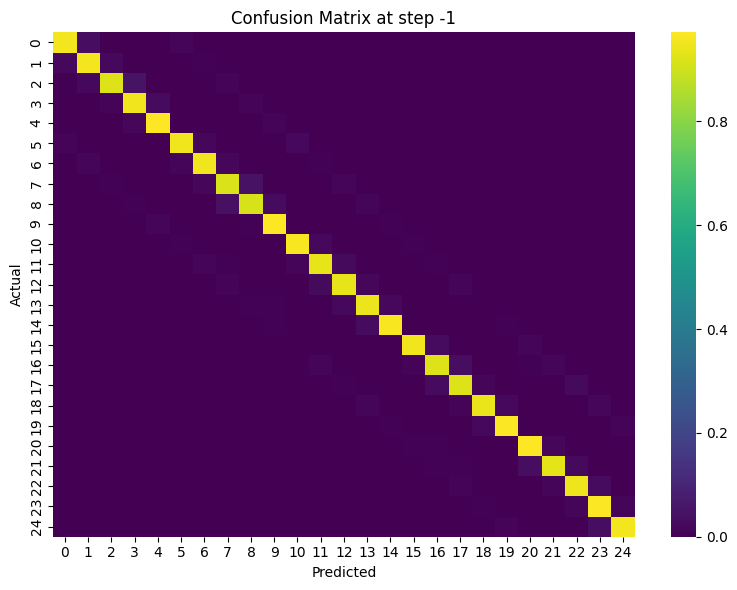

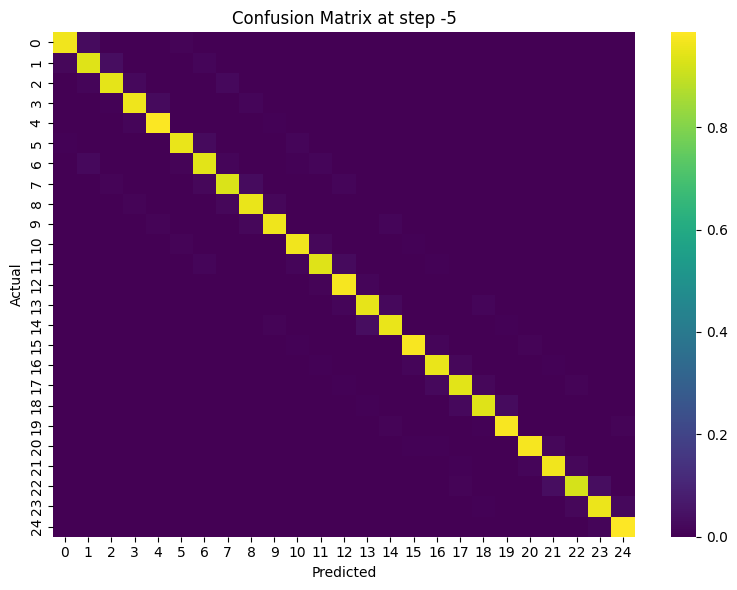

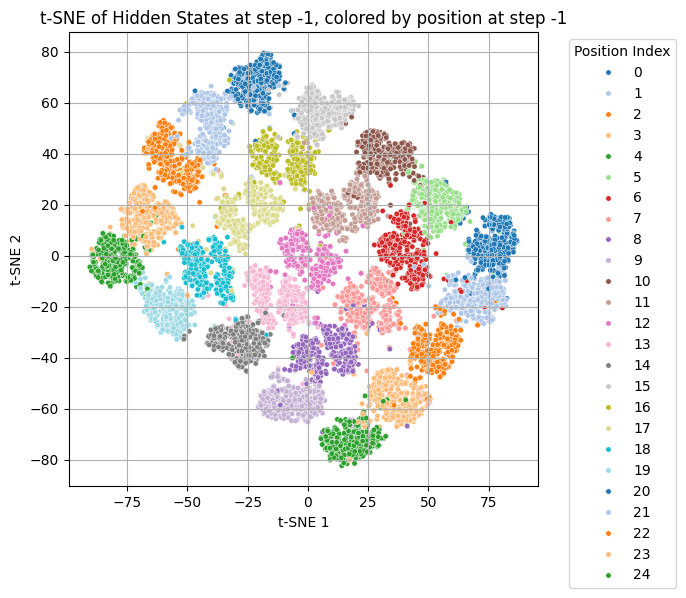

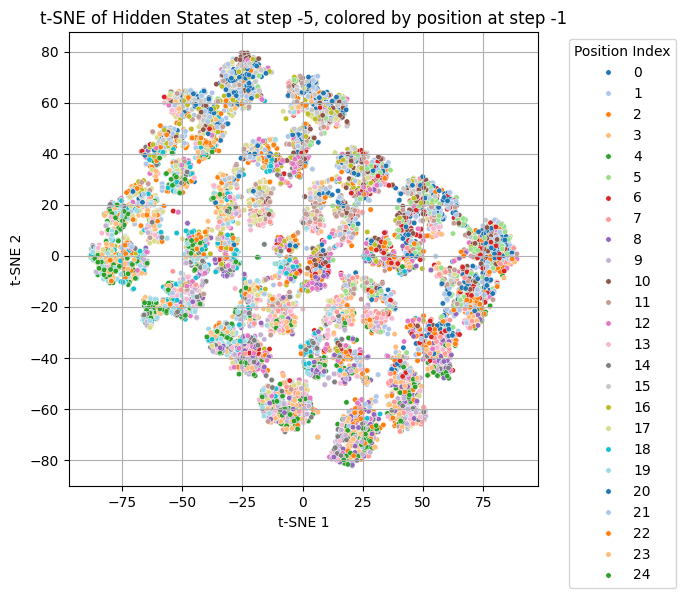

C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


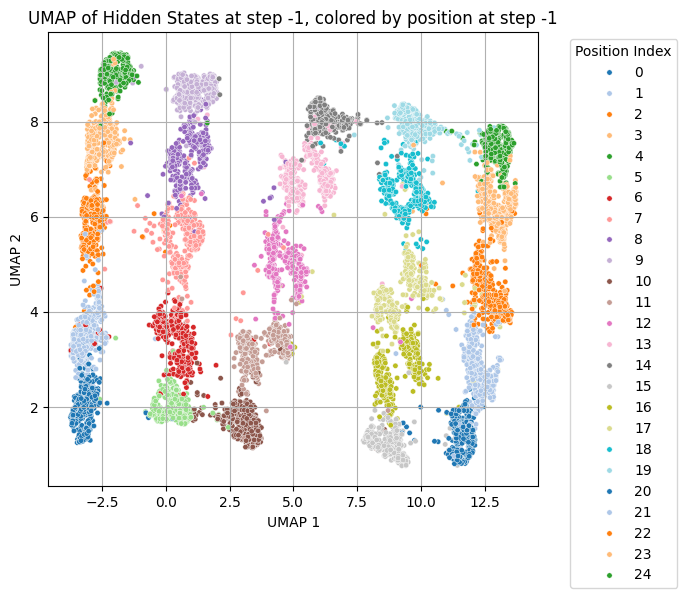

C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


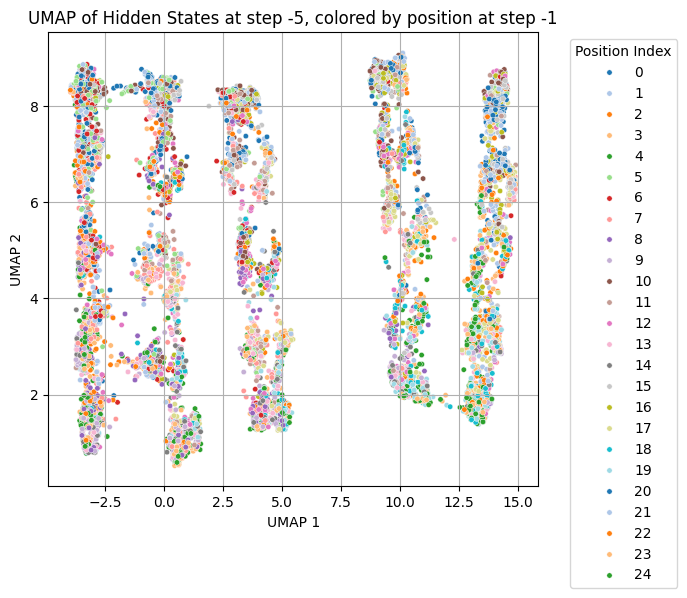

                    Metric     Value
0  Generalization Accuracy  0.870527


In [7]:
"""Run everything and define the hyperparameters."""

grid_size = (5, 5)
max_length = 40
batch_size = 1000
epochs = 100
train_sample_size = 50_000
test_sample_size = 10_000
n_back = 10
hidden_units = 128
lr = 0.001
device = torch.device("cpu")

train_ds = create_n_back_dataset(train_sample_size, n=n_back, max_length=max_length, grid_size=np.array(grid_size))
test_ds = create_n_back_dataset(test_sample_size, n=n_back, max_length=max_length, grid_size=np.array(grid_size))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)
model = OneHotRNN(hidden_size=128, output_size=25, cell_type='gru', num_layers=1, dropout=0.2)

print(f"Training model with {train_sample_size} samples, {test_sample_size} test samples, and n_back={n_back}")
accuracy = train_and_test(model, train_loader, test_loader, epochs=epochs, lr=lr, device=device, n_back=n_back)
print(f"Generalization Accuracy: {accuracy:.4f}")

# Plot heatmap:
plot_confusion_matrix(model, test_ds, grid_size=(5,5), step=-1, device=device)
plot_confusion_matrix(model, test_ds, grid_size=(5,5), step=-5, device=device)

# Enhanced t-SNE visualization:
enhanced_tsne_analysis(model, test_ds, step_pos=-1, step_hidden=-1)
enhanced_tsne_analysis(model, test_ds, step_pos=-1, step_hidden=-5)

# Enhanced UMAP visualization:
enhanced_umap_analysis(model, test_ds, step_pos=-1, step_hidden=-1)
enhanced_umap_analysis(model, test_ds, step_pos=-1, step_hidden=-5)

df = pd.DataFrame({
    "Metric": ["Generalization Accuracy"],
    "Value": [accuracy]
})

print(df)

Training for n-back = 1...


C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Training for n-back = 2...
Training for n-back = 3...
Training for n-back = 4...
Training for n-back = 5...
Training for n-back = 6...
Training for n-back = 7...
Training for n-back = 8...


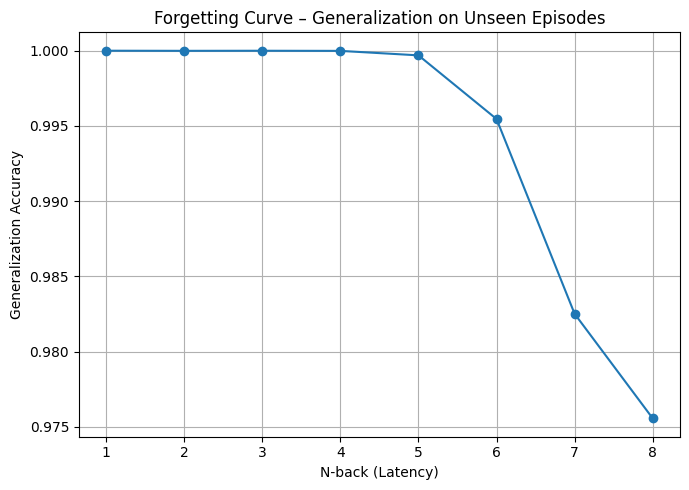

In [8]:
"""Compute the forgetting curve for different n-back values."""

def compute_forgetting_curve(n_back_values, train_sample_size, test_sample_size, grid_size, 
                             input_size, hidden_size, output_size, cell_type, batch_size, 
                             epochs, lr, device='cpu', boundary='strict'):
    acc_by_n = []

    for n in n_back_values:
        print(f"Training for n-back = {n}...")
        # Generate datasets:
        train_ds = create_n_back_dataset(train_sample_size, n=n, grid_size=np.array(grid_size), boundary=boundary)
        test_ds = create_n_back_dataset(test_sample_size, n=n, grid_size=np.array(grid_size), boundary=boundary)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size)

        # Init model:
        model = OneHotRNN(hidden_size=128, output_size=25, cell_type='gru', num_layers=1, dropout=0.2)
        acc = train_and_test(model, train_loader, test_loader, epochs=epochs, lr=lr, device=device, n_back=n)
        acc_by_n.append(acc)

    return acc_by_n

def plot_forgetting_curve(n_back_values, accuracies):
    plt.figure(figsize=(7, 5))
    plt.plot(n_back_values, accuracies, '-o')
    plt.xlabel("N-back (Latency)")
    plt.ylabel("Generalization Accuracy")
    plt.title("Forgetting Curve – Generalization on Unseen Episodes")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
n_back_range = list(range(1, 9)) # Define the range of n-back values to test.
accuracies = compute_forgetting_curve(
    n_back_values=n_back_range,
    train_sample_size=50000,
    test_sample_size=10000,
    grid_size=(5, 5),
    input_size=16,
    hidden_size=128,
    output_size=25,
    cell_type='gru',
    batch_size=512,
    epochs=50,
    lr=0.001,
    device='cpu',
    boundary='strict'
)

plot_forgetting_curve(n_back_range, accuracies)

In [9]:
""" LTSM Model Definition. """

# Define an LSTM-based RNN model (replacing GRU with LSTM)
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTMModel, self).__init__()
#         self.embed = nn.Embedding(4, input_size)
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x, return_hidden=False):
#         x = self.embed(x)
#         out, (h_n, c_n) = self.lstm(x)
#         logits = self.fc(out)
#         if return_hidden:
#             return logits, out
#         return logits

# # Summary for user
# model_summary = str(LSTMModel)
# model_summary


' LTSM Model Definition. '

In [10]:
""" GRU Model Definition. """

# RNN base model(gru):
# class BaseRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, cell_type='gru'):
#         super(BaseRNN, self).__init__()
#         self.embed = nn.Embedding(4, input_size)
#         rnn_cls = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[cell_type]
#         self.rnn = rnn_cls(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x, return_hidden=False):
#         x = self.embed(x)
#         out, h = self.rnn(x)
#         logits = self.fc(out)
#         if return_hidden:
#             return logits, out
#         return logits

' GRU Model Definition. '